In [1]:
from pathlib import Path  # for path handling
import pydicom # to read dicom files
import numpy as np  
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm # to get a nice progress bar
import os

import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [2]:
labels = pd.read_csv('/kaggle/input/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')
labels.head(10)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


In [3]:
# to enable autocomplete in kaggle
%config Completer.use_jedi = False

In [4]:
labels = labels.drop_duplicates('patientId')

In [5]:
ROOT_DIR = '../input/rsna-pneumonia-detection-challenge'
ROOT_PATH = Path(ROOT_DIR+'/stage_2_train_images')
SAVE_PATH = Path(ROOT_DIR+'Processed')

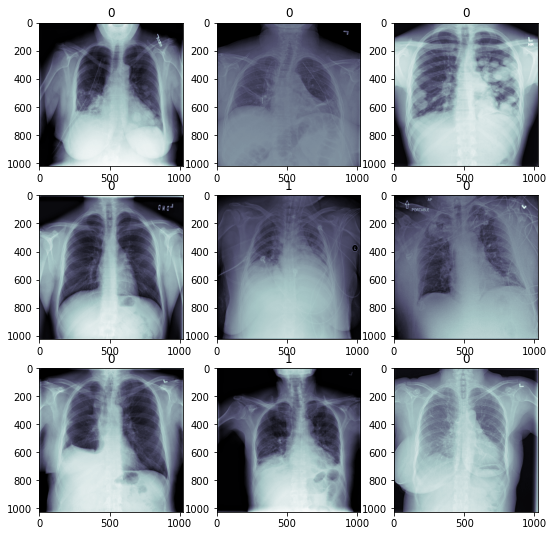

In [6]:
fig, axis = plt.subplots(3, 3, figsize=(9,9))

c = 0
for i in range(3):
    for j in range(3):
        patientId = labels.patientId.iloc[c]
        dcmPath = ROOT_PATH/patientId
        dcmPath = dcmPath.with_suffix('.dcm')
        dcmFile = pydicom.read_file(dcmPath).pixel_array
        label = labels.Target.iloc[c]
        
        axis[i][j].imshow(dcmFile, cmap='bone')
        axis[i][j].set_title(label)
        c+=1

In [7]:
mean, std = np.array([]), np.array([])

to_tensor_transform = transforms.Compose([
    transforms.ToTensor()
])

for c, patiendId in enumerate(tqdm(labels.patientId)):
    patientId = labels.patientId.iloc[c]
    dcmPath = ROOT_PATH/patientId
    dcmPath = dcmPath.with_suffix('.dcm')
    dcmFile = pydicom.read_file(dcmPath).pixel_array / 225
    
    dcmArray = cv2.resize(dcmFile, (224,224)).astype(np.float16)
    label = labels.Target.iloc[c]
    
    trainOrVal = "train" if  c< 24000 else 'val'
    
    path = Path(f"{trainOrVal}/{str(label)}")
    path.mkdir(parents=True, exist_ok=True)
    np.save(path/patiendId, dcmArray)
    
    if trainOrVal == "train":    
        imageTensor = to_tensor_transform(dcmFile)
        mean = np.append(mean, imageTensor.mean([1,2]))
        std = np.append(std, imageTensor.std([1,2]))

  0%|          | 0/26684 [00:00<?, ?it/s]

In [8]:
train_image_mean = mean.mean()
train_image_std = std.std()
train_image_mean, train_image_std

(0.5552768712813766, 0.04827989392646837)

In [9]:
def load_file(path):
    return np.load(path).astype(np.float32)


train_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize(train_image_mean, train_image_std),  # Use mean and std calculated in preprocessing notebook
                                    transforms.RandomAffine( # Data Augmentation
                                        degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),
                                        transforms.RandomResizedCrop((224, 224), scale=(0.35, 1))

])

val_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize([train_image_mean], [train_image_std]),  # Use mean and std calculated in preprocessing notebook
])

In [10]:
train_dataset = torchvision.datasets.DatasetFolder(
    "train/",
    loader=load_file, extensions="npy", transform=train_transforms)

val_dataset = torchvision.datasets.DatasetFolder(
    "val/",
    loader=load_file, extensions="npy", transform=val_transforms)

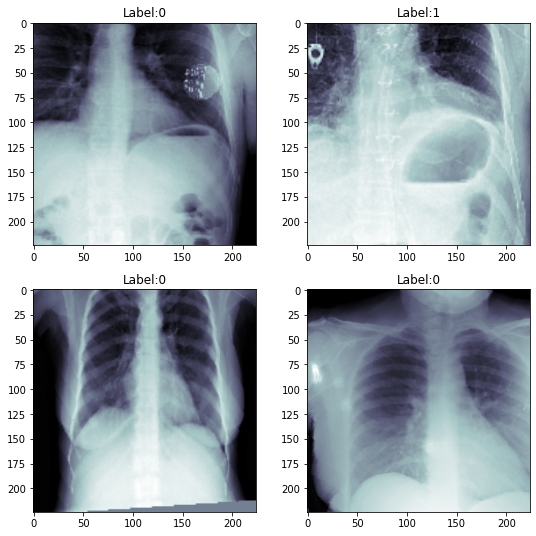

In [11]:
fig, axis = plt.subplots(2, 2, figsize=(9, 9))
for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, 20000)
        x_ray, label = train_dataset[random_index]
        axis[i][j].imshow(x_ray[0], cmap="bone")
        axis[i][j].set_title(f"Label:{label}")

In [12]:
batch_size = 64 
num_workers = 4

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 24000 train images and 2684 val images


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [13]:
np.unique(train_dataset.targets, return_counts=True), np.unique(val_dataset.targets, return_counts=True)

((array([0, 1]), array([18593,  5407])), (array([0, 1]), array([2079,  605])))

In [14]:
class PneumoniaModel(pl.LightningModule):
    def __init__(self, weight=1):
        super().__init__()
        
        self.model = torchvision.models.resnet18()
        # change conv1 from 3 to 1 input channels
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # change out_feature of the last fully connected layer (called fc in resnet18) from 1000 to 1
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight]))
        
        # simple accuracy computation
        self.train_acc = torchmetrics.Accuracy()
        self.val_acc = torchmetrics.Accuracy()

    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()  # Convert label to float (just needed for loss computation)
        pred = self(x_ray)[:,0]  # Prediction: Make sure prediction and label have same shape
        loss = self.loss_fn(pred, label)  # Compute the loss
        
        # Log loss and batch accuracy
        self.log("Train Loss", loss)
        self.log("Step Train Acc", self.train_acc(torch.sigmoid(pred), label.int()))
        return loss
    
    
    def training_epoch_end(self, outs):
        # After one epoch compute the whole train_data accuracy
        self.log("Train Acc", self.train_acc.compute())
        
        
    def validation_step(self, batch, batch_idx):
        # Same steps as in the training_step
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:,0]  # make sure prediction and label have same shape

        loss = self.loss_fn(pred, label)
        
        # Log validation metrics
        self.log("Val Loss", loss)
        self.log("Step Val Acc", self.val_acc(torch.sigmoid(pred), label.int()))
        return loss
    
    def validation_epoch_end(self, outs):
        self.log("Val Acc", self.val_acc.compute())
    
    def configure_optimizers(self):
        #Caution! You always need to return a list here (just pack your optimizer into one :))
        return [self.optimizer]

In [15]:
model = PneumoniaModel()

# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='Val Acc',
    save_top_k=10,
    dirpath='weights/',
    filename="model-{epoch:02d}-{val_loss:.2f}",
    mode='max')

# Create the trainer
# Change the gpus parameter to the number of available gpus on your system. Use 0 for CPU training

gpus = 1
trainer = pl.Trainer(gpus=gpus, logger=TensorBoardLogger(save_dir="./logs"), log_every_n_steps=1,
                     callbacks=checkpoint_callback,
                     max_epochs=35)


In [16]:
trainer.fit(model, train_loader, val_loader)

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

# Evaluation

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Use strict=False, otherwise we would want to match the pos_weight which is not necessary
model = PneumoniaModel.load_from_checkpoint("./weights/model-epoch=33-val_loss=0.00.ckpt")
model.eval()
model.to(device);

In [18]:
for dirname, _, filenames in os.walk('./weights'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./weights/model-epoch=26-val_loss=0.00.ckpt
./weights/model-epoch=28-val_loss=0.00.ckpt
./weights/model-epoch=34-val_loss=0.00.ckpt
./weights/model-epoch=30-val_loss=0.00.ckpt
./weights/model-epoch=32-val_loss=0.00.ckpt
./weights/model-epoch=27-val_loss=0.00.ckpt
./weights/model-epoch=29-val_loss=0.00.ckpt
./weights/model-epoch=33-val_loss=0.00.ckpt
./weights/model-epoch=25-val_loss=0.00.ckpt
./weights/model-epoch=31-val_loss=0.00.ckpt


In [19]:
preds = []
labels = []

with torch.no_grad():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model(data)[0].cpu())
        preds.append(pred)
        labels.append(label)
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()

  0%|          | 0/2684 [00:00<?, ?it/s]

In [20]:
acc = torchmetrics.Accuracy()(preds, labels)
precision = torchmetrics.Precision()(preds, labels)
recall = torchmetrics.Recall()(preds, labels)
cm = torchmetrics.ConfusionMatrix(num_classes=2)(preds, labels)
cm_threshed = torchmetrics.ConfusionMatrix(num_classes=2, threshold=0.25)(preds, labels)

print(f"Val Accuracy: {acc}")
print(f"Val Precision: {precision}")
print(f"Val Recall: {recall}")
print(f"Confusion Matrix:\n {cm}")
print(f"Confusion Matrix 2:\n {cm_threshed}")

Val Accuracy: 0.8420268297195435
Val Precision: 0.6771036982536316
Val Recall: 0.5719008445739746
Confusion Matrix:
 tensor([[1914.,  165.],
        [ 259.,  346.]])
Confusion Matrix 2:
 tensor([[1653.,  426.],
        [ 115.,  490.]])


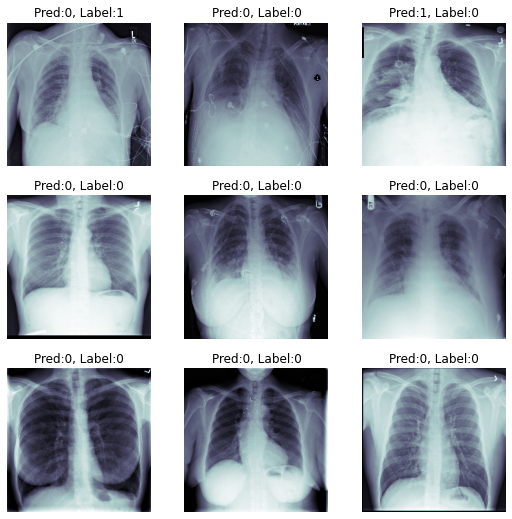

In [21]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
    for j in range(3):
        rnd_idx = np.random.randint(0, len(preds))
        axis[i][j].imshow(val_dataset[rnd_idx][0][0], cmap="bone")
        axis[i][j].set_title(f"Pred:{int(preds[rnd_idx] > 0.5)}, Label:{labels[rnd_idx]}")
        axis[i][j].axis("off")